In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

In [2]:
# دانلود و آماده‌سازی داده‌های CIFAR-100
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# تبدیل کل داده‌های آموزشی به بردارهای تخت و جمع اوری تصاویر
data_list = []
images_list = []
for images, labels in trainloader:
    data_list.append(images.view(images.size(0), -1))
    images_list.append(images)
data = torch.cat(data_list, dim=0)
all_images = torch.cat(images_list, dim=0)

100%|██████████| 169M/169M [00:02<00:00, 69.9MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


In [3]:
class KohonenSOM(nn.Module):
    def __init__(self, input_dim, grid_size, learning_rate=0.2, sigma=1.0):
        super(KohonenSOM, self).__init__()
        self.grid_size = grid_size
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = nn.Parameter(torch.randn(grid_size * grid_size, input_dim))
        self.locations = self._create_locations(grid_size)

    def _create_locations(self, grid_size):
        locations = []
        for x in range(grid_size):
            for y in range(grid_size):
                locations.append(np.array([x, y]))
        return np.array(locations)

    def _neighborhood(self, winner, epoch, num_epochs):
        sigma = self.sigma * (1 - epoch / num_epochs)
        sq_distances = np.sum((self.locations - self.locations[winner]) ** 2, axis=1)
        return np.exp(-sq_distances / (2 * sigma ** 2))

    def forward(self, x):
        x = x.unsqueeze(0)
        x = x.expand(self.grid_size * self.grid_size, -1)
        weights = self.weights
        dists = torch.norm(x - weights, dim=1)
        winners = torch.argmin(dists, dim=0)
        return winners

    def train_som(self, data, num_epochs=100):
        for epoch in range(num_epochs):
            for i in range(data.shape[0]):
                x = data[i]
                winner = self.forward(x).item()
                self.update_weights(x, winner, epoch, num_epochs)

    def update_weights(self, x, winner, epoch, num_epochs):
        neighborhood = self._neighborhood(winner, epoch, num_epochs)
        learning_rate = self.learning_rate * (1 - epoch / num_epochs)
        for i in range(len(neighborhood)):
            self.weights.data[i] += learning_rate * neighborhood[i] * (x - self.weights.data[i])


در اینجا یک ماتریس را پیاده سازی کرده ایم که هر خانه اش میانگین فاصله نورون مربوطه از نورون همسایگانش را نمایش میدهد

In [4]:
# U-Matrix
def calculate_u_matrix(weights, grid_size):
    distances = pairwise_distances(weights, metric='euclidean')
    u_matrix = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            neighbors = [idx - 1, idx + 1, idx - grid_size, idx + grid_size]
            valid_neighbors = [n for n in neighbors if 0 <= n < grid_size * grid_size]
            u_matrix[i, j] = np.mean([distances[idx, n] for n in valid_neighbors])
    return u_matrix

در 3 قسمت بعدی 3 مدل جداگانه ترین کرده ایم و خروجی های حاصل شده را روی مپ کوهونن نمایش داده ایم. در هر قسمت مپ را این گونه نمایش میدهیم که هر خانه جدول میانگین تصاویری که نورون مربوطه به آن برنده شده است را نمایش میدهد. همچنین ماتریسی که در بالا تعریف کرده ایم نیز نشان داده شده است. اگر دقت کنید مدل 2 نسبت به مدل اول بهتر عمل کرده چرا که تعداد ایپاک ها بیشتر شده. به دلیل طولانی شدن فرایند اموزش خیلی تعداد ایپاک را بزرگ در نظر نگرفته ایم. همچنین در شکل آخر مپ کوهونن را بزرگ تر کرده ایم که نسبتا خوب عمل کرده است

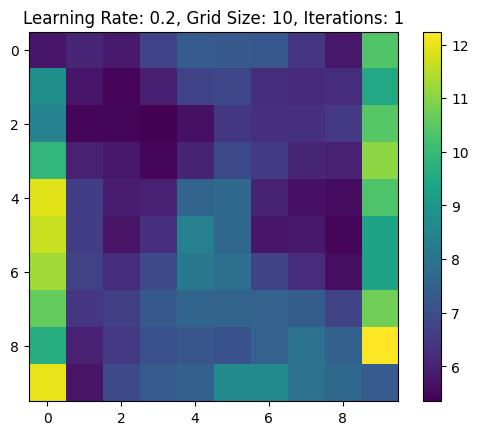

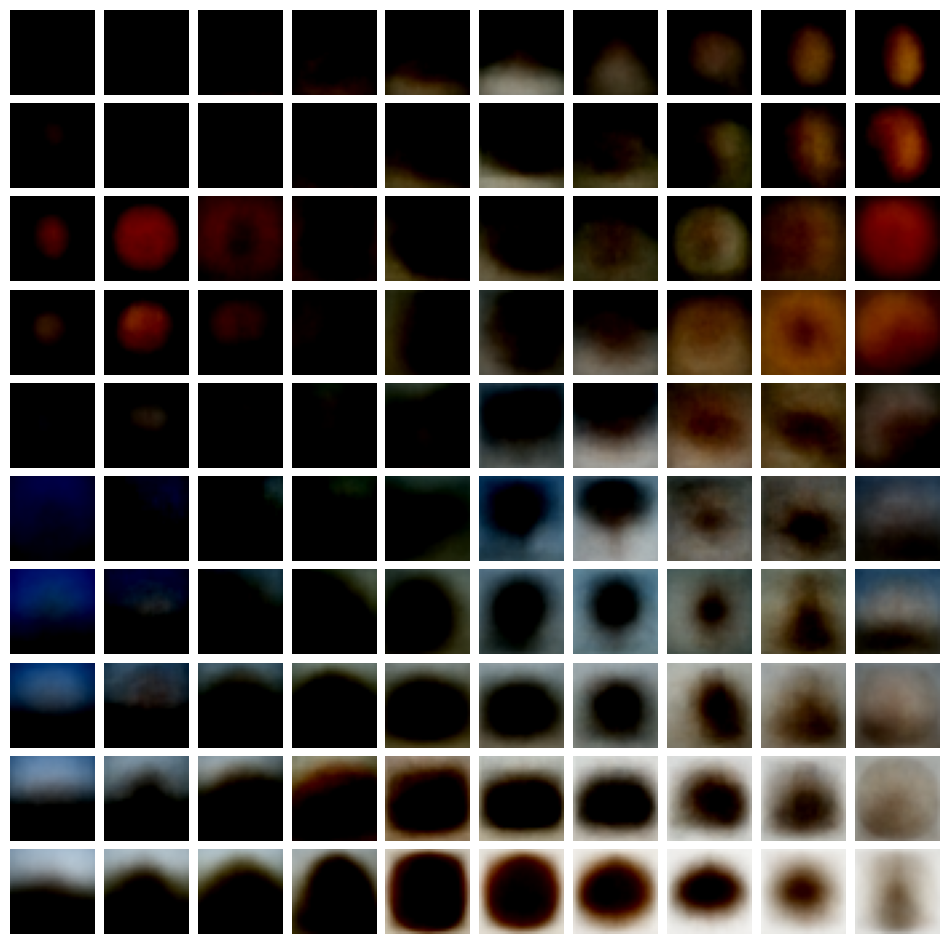

In [7]:
# تعریف و آموزش شبکه Kohonen
input_dim = data.shape[1]
grid_size = 10
learning_rate = 0.2
num_epochs = 1

som = KohonenSOM(input_dim, grid_size, learning_rate, sigma=1.0)
som.train_som(data, num_epochs)

u_matrix = calculate_u_matrix(som.weights.detach().numpy(), grid_size)
plt.imshow(u_matrix, cmap='viridis')
plt.colorbar()
plt.title(f'Learning Rate: {learning_rate}, Grid Size: {grid_size}, Iterations: {num_epochs}')
plt.show()

# محاسبه برنده‌ها برای داده‌های آموزشی
winners = []
for i in range(data.shape[0]):
    x = data[i]
    winner = som.forward(x).item()
    winners.append(winner)

winners = np.array(winners)

# ایجاد نقشه با میانگین تصاویر نماینده
map_shape = (grid_size, grid_size, 3, 32, 32)
image_map = np.zeros(map_shape)

# ایجاد لیستی از تصاویر برای هر نورون
image_list_per_neuron = [[] for _ in range(grid_size * grid_size)]

for i, win in enumerate(winners):
    image_list_per_neuron[win].append(all_images[i].numpy())

# محاسبه میانگین تصاویر برای هر نورون
for i in range(grid_size * grid_size):
    if len(image_list_per_neuron[i]) > 0:
        image_map[np.unravel_index(i, (grid_size, grid_size))] = np.mean(image_list_per_neuron[i], axis=0)

# تبدیل ابعاد تصاویر برای رسم
image_map = np.transpose(image_map, (0, 1, 3, 4, 2))

# رسم نقشه با استفاده از Matplotlib
fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))

for i in range(grid_size):
    for j in range(grid_size):
        if not np.all(image_map[i, j] == 0):  # نمایش تنها نودهایی که تصویر دارند
            ax[i, j].imshow(image_map[i, j])
        ax[i, j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

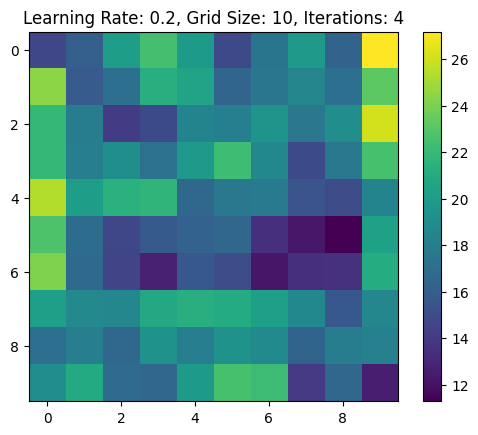

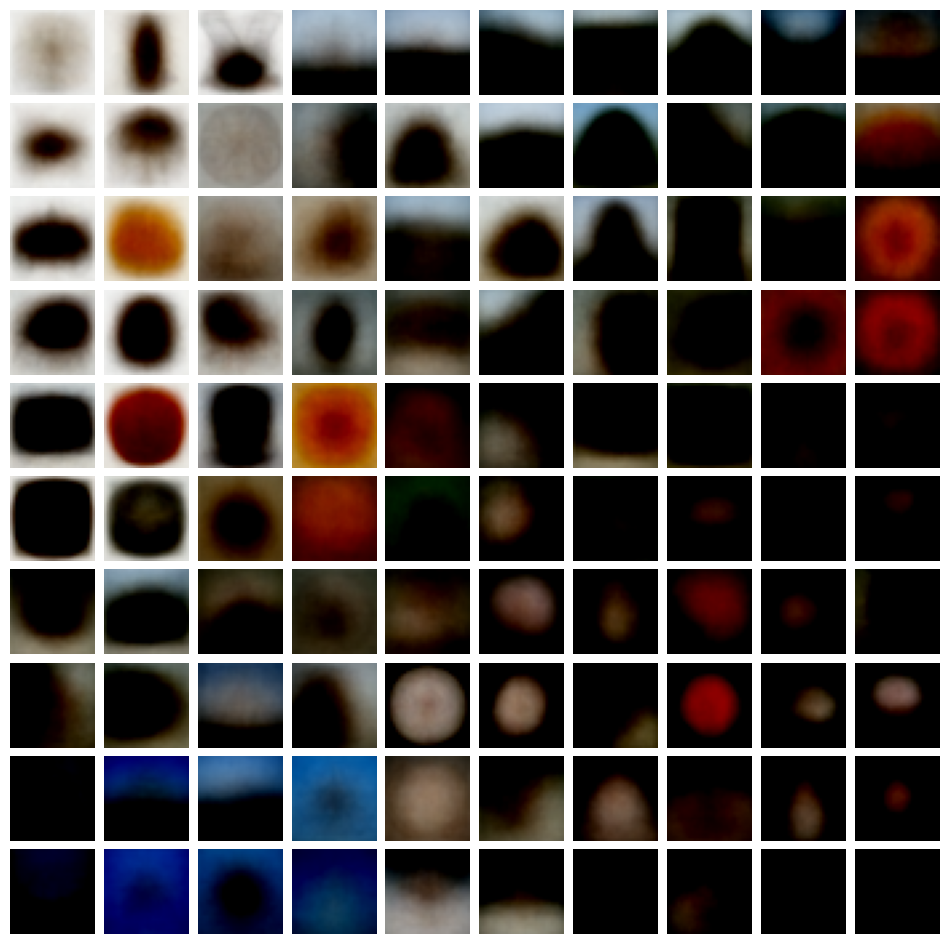

In [6]:
# تعریف و آموزش شبکه Kohonen
input_dim = data.shape[1]
grid_size = 10
learning_rate = 0.2
num_epochs = 4

som = KohonenSOM(input_dim, grid_size, learning_rate, sigma=1.0)
som.train_som(data, num_epochs)

u_matrix = calculate_u_matrix(som.weights.detach().numpy(), grid_size)
plt.imshow(u_matrix, cmap='viridis')
plt.colorbar()
plt.title(f'Learning Rate: {learning_rate}, Grid Size: {grid_size}, Iterations: {num_epochs}')
plt.show()

# محاسبه برنده‌ها برای داده‌های آموزشی
winners = []
for i in range(data.shape[0]):
    x = data[i]
    winner = som.forward(x).item()
    winners.append(winner)

winners = np.array(winners)

# ایجاد نقشه با میانگین تصاویر نماینده
map_shape = (grid_size, grid_size, 3, 32, 32)
image_map = np.zeros(map_shape)

# ایجاد لیستی از تصاویر برای هر نورون
image_list_per_neuron = [[] for _ in range(grid_size * grid_size)]

for i, win in enumerate(winners):
    image_list_per_neuron[win].append(all_images[i].numpy())

# محاسبه میانگین تصاویر برای هر نورون
for i in range(grid_size * grid_size):
    if len(image_list_per_neuron[i]) > 0:
        image_map[np.unravel_index(i, (grid_size, grid_size))] = np.mean(image_list_per_neuron[i], axis=0)

# تبدیل ابعاد تصاویر برای رسم
image_map = np.transpose(image_map, (0, 1, 3, 4, 2))

# رسم نقشه با استفاده از Matplotlib
fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))

for i in range(grid_size):
    for j in range(grid_size):
        if not np.all(image_map[i, j] == 0):  # نمایش تنها نودهایی که تصویر دارند
            ax[i, j].imshow(image_map[i, j])
        ax[i, j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

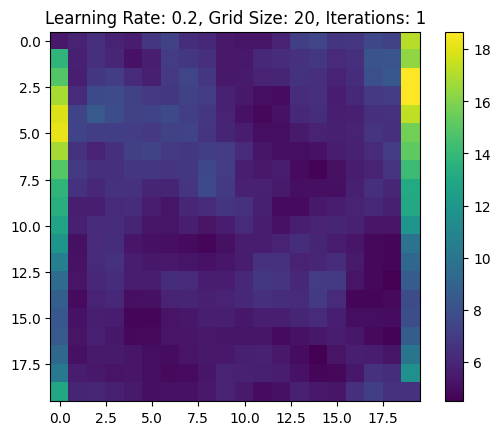

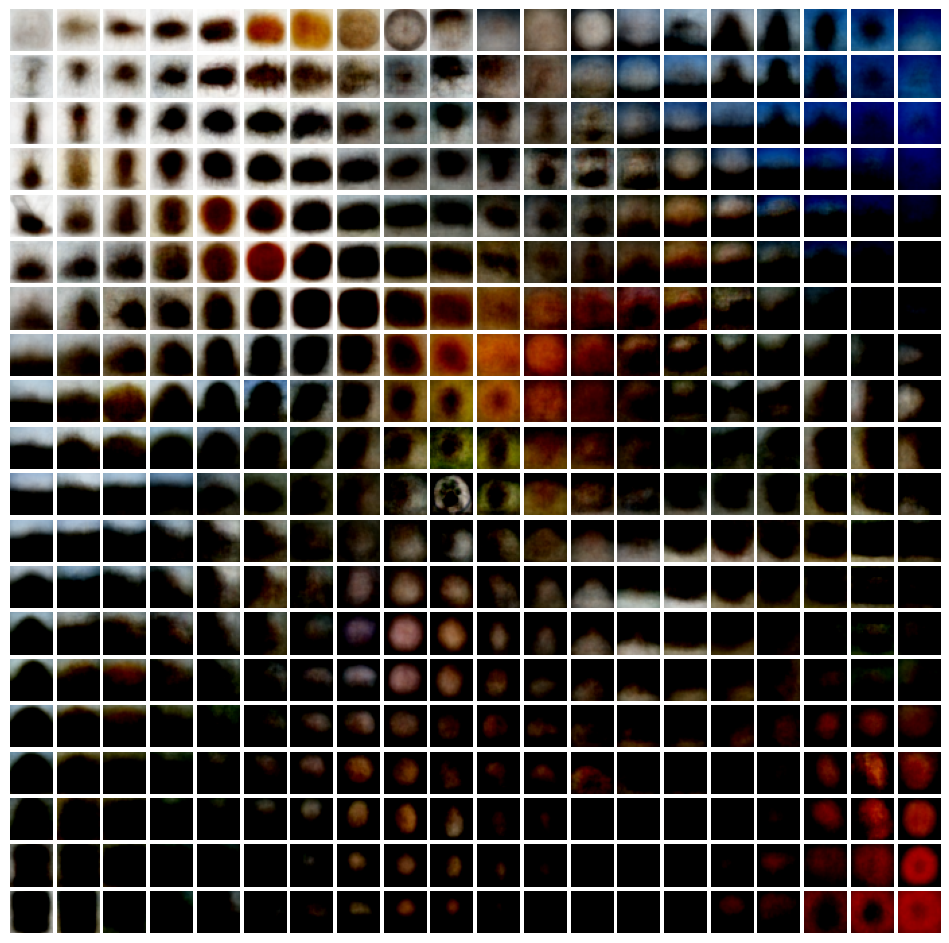

In [5]:
# تعریف و آموزش شبکه Kohonen
input_dim = data.shape[1]
grid_size = 20
learning_rate = 0.2
num_epochs = 1

som = KohonenSOM(input_dim, grid_size, learning_rate, sigma=1.0)
som.train_som(data, num_epochs)

u_matrix = calculate_u_matrix(som.weights.detach().numpy(), grid_size)
plt.imshow(u_matrix, cmap='viridis')
plt.colorbar()
plt.title(f'Learning Rate: {learning_rate}, Grid Size: {grid_size}, Iterations: {num_epochs}')
plt.show()

# محاسبه برنده‌ها برای داده‌های آموزشی
winners = []
for i in range(data.shape[0]):
    x = data[i]
    winner = som.forward(x).item()
    winners.append(winner)

winners = np.array(winners)

# ایجاد نقشه با میانگین تصاویر نماینده
map_shape = (grid_size, grid_size, 3, 32, 32)
image_map = np.zeros(map_shape)

# ایجاد لیستی از تصاویر برای هر نورون
image_list_per_neuron = [[] for _ in range(grid_size * grid_size)]

for i, win in enumerate(winners):
    image_list_per_neuron[win].append(all_images[i].numpy())

# محاسبه میانگین تصاویر برای هر نورون
for i in range(grid_size * grid_size):
    if len(image_list_per_neuron[i]) > 0:
        image_map[np.unravel_index(i, (grid_size, grid_size))] = np.mean(image_list_per_neuron[i], axis=0)

# تبدیل ابعاد تصاویر برای رسم
image_map = np.transpose(image_map, (0, 1, 3, 4, 2))

# رسم نقشه با استفاده از Matplotlib
fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))

for i in range(grid_size):
    for j in range(grid_size):
        if not np.all(image_map[i, j] == 0):  # نمایش تنها نودهایی که تصویر دارند
            ax[i, j].imshow(image_map[i, j])
        ax[i, j].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()